In [46]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import resnet18, resnet50
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
import torch.nn.functional as F
import math
import numpy as np

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 1

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

model = models.resnet50(pretrained=False)  # pretrained=False as you are loading trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(torch.load('/kaggle/input/resnet_50_cifar100/pytorch/default/1/resnet50_10epoch_cifar100.pth', map_location=device))

model = model.to(device)
model.eval()

num_images = len(test_dataset)  # Get the number of images
print(f'Number of images in the validation folder: {num_images}')

values = np.linspace(0, 1, 16)
thresholds = [round(i, 4) for i in values]

print(thresholds)
num_thresholds = len(thresholds)

def quantize_to_8bit(probabilities):
    # Ensure probabilities are in the [0, 1] range
    probabilities = torch.clamp(probabilities, 0, 1)
    
    # Scale probabilities to 255 intervals, round to the nearest one, and then scale back
    quantized = torch.round(probabilities * 15) / 15
    
    return quantized


Files already downloaded and verified


/tmp/ipykernel_30/2758435204.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/resnet_50_cifar100/pytorch/default/1/resnet

Number of images in the validation folder: 10000
[0.0, 0.0667, 0.1333, 0.2, 0.2667, 0.3333, 0.4, 0.4667, 0.5333, 0.6, 0.6667, 0.7333, 0.8, 0.8667, 0.9333, 1.0]


In [48]:
correct = 0
incorrect = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        
        # Get predicted classes and their associated probabilities
        predicted_probs, predicted_labels = torch.max(softmax_probs, dim=1)

        # Check which predictions are correct
        correct_predictions = (predicted_labels == labels)
        incorrect_predictions = (predicted_labels != labels)
        
        # Update the accuracy counters
        total += labels.size(0)
        correct += correct_predictions.sum().item()
        incorrect += incorrect_predictions.sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 50.14%


In [49]:
print(correct, incorrect, total)

5014 4986 10000


In [50]:
# Algorithm - All offload
cost_all_offload = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    # Calculate the cost for all offload
    temp = round(alpha * num_images, 2)
    cost_all_offload.append(temp)
    
print(f"Cost for all offload Algorithm with increasing alpha: {cost_all_offload}")

Cost for all offload Algorithm with increasing alpha: [0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0]


In [51]:
# Algorithm - No offload
number_of_incorrectly_classified_images = incorrect
cost_no_offload = [number_of_incorrectly_classified_images]*11
print(number_of_incorrectly_classified_images)
print(f"Cost for no offload Algorithm is: {cost_no_offload}")

4986
Cost for no offload Algorithm is: [4986, 4986, 4986, 4986, 4986, 4986, 4986, 4986, 4986, 4986, 4986]


In [52]:
# Algorithm - Offline optimal
cost_offline_optimal = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_current_alpha = 0.0  # Reset cost for each alpha

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            # Calculate cost based on prediction accuracy
            if pred_class != true_class:
                cost_current_alpha += alpha  # Increment cost by alpha for incorrect predictions

    # Store the calculated cost for the current alpha in the list
    cost_offline_optimal.append(cost_current_alpha)

# Print the list of costs for offline optimal algorithm
print(f"Cost for offline optimal Algorithm is: {cost_offline_optimal}")


Cost for offline optimal Algorithm is: [0.0, 501.4000000000455, 1002.800000000091, 1504.1999999998634, 2005.600000000182, 2507.0, 3008.399999999727, 3509.799999999714, 4011.200000000364, 4512.600000000124, 5014.0]


In [53]:
# Algorithm - LCB UCB algorithm
delta = 1/math.e

# List to store costs for each alpha
cost_LCB_UCB_list = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_LCB_UCB = 0.0  # Reset cost for each alpha

    # Initialize or reset dictionaries for each alpha iteration
    dict = {
        'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
        'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
        'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
        'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
    }
    
    correct_counts = {threshold: 0 for threshold in thresholds}
    offloads_counts = {threshold: 0 for threshold in thresholds}
    total_counts = {threshold: 0 for threshold in thresholds}

    # Process each batch of images
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)
            pred_class = predicted_labels.item()
            true_class = labels.item()

            total_counts[pred_probs] += 1

            # Apply the LCB UCB conditions
            if dict['LCB'][pred_probs] >= (1 - alpha):
                if pred_class == true_class:
                    cost_LCB_UCB += 0
                else:
                    cost_LCB_UCB += 1

            elif dict['UCB'][pred_probs] <= (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_LCB_UCB += alpha

            log_delta = math.log(1 / delta)
            uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

            dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
            dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

            # Update bounds for each threshold
            for x1 in thresholds:
                if x1 <= pred_probs:
                    for x in thresholds:
                        if x1 <= x <= pred_probs:
                            dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

            for x2 in thresholds:
                if x2 >= pred_probs:
                    for x in thresholds:
                        if x2 >= x >= pred_probs:
                            dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

    # Store the cost for the current alpha value in the list
    cost_LCB_UCB_list.append(cost_LCB_UCB)

# Print the entire list of costs for each alpha
print("Cost values for each alpha:", cost_LCB_UCB_list)


Cost values for each alpha: [0.0, 977.1000000001409, 1823.2000000002474, 2572.5000000000764, 3275.200000000409, 3868.5, 4373.999999999848, 4923.699999999854, 4991.200000000192, 5071.100000000015, 5014.0]


In [54]:
# Algorithm - LCB UCB without structural information
delta = 1 / math.e

# List to store costs for each alpha
cost_no_info_list = []

for alpha in [round(i * 0.1, 1) for i in range(11)]:
    cost_no_info = 0.0  # Reset cost for each alpha

    dict = {
        'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
        'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
        'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
        'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
    }

    correct_counts = {threshold: 0 for threshold in thresholds}
    offloads_counts = {threshold: 0 for threshold in thresholds}
    total_counts = {threshold: 0 for threshold in thresholds}

    count = 1  # Initialize image counter

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            total_counts[pred_probs] += 1

            # Apply the LCB UCB conditions
            if dict['LCB'][pred_probs] >= (1 - alpha):
                if pred_class != true_class:
                    cost_no_info += 1

            elif dict['UCB'][pred_probs] <= (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_no_info += alpha

            elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
                dict['Tx'][pred_probs] += 1
                if pred_class == true_class:
                    correct_counts[pred_probs] += 1
                dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
                offloads_counts[pred_probs] += 1
                cost_no_info += alpha

            log_delta = math.log(1 / delta)
            uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

            dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
            dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

    # Store the cost for the current alpha value in the list
    cost_no_info_list.append(cost_no_info)

# Print the entire list of costs for each alpha
print("Cost values for each alpha:", cost_no_info_list)


Cost values for each alpha: [0.0, 991.400000000151, 1812.800000000242, 2581.8000000000893, 3265.400000000393, 3897.0, 4373.3999999998305, 4766.699999999751, 4985.000000000185, 5077.099999999989, 5014.0]


In [55]:
# Algorithm - Hedge
def choose_threshold(weights, thresholds, W_t):
    # Create probability distribution for selecting a threshold
    probabilities = np.array([weights[theta] / W_t for theta in thresholds])
    
    # Choose a threshold based on the weight distribution
    chosen_threshold_idx = np.random.choice(len(thresholds), p=probabilities)
    chosen_threshold = thresholds[chosen_threshold_idx]
    
    return chosen_threshold

cost_hedge_list = []

# Iterate over different values of alpha
for alpha in np.arange(0, 1.1, 0.1):
    η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
    ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

    cost_hedge = 0.0
    weights = {threshold: 1.0 for threshold in thresholds}  # Initialize weights for each threshold
    W_t = sum(weights.values())  # Sum the initial weights to get W_t
    incorrect_count = {threshold: 0 for threshold in thresholds}
    correct_count = {threshold: 0 for threshold in thresholds}
    offload_count = {threshold: 0 for threshold in thresholds}
    total_count = {threshold: 0 for threshold in thresholds}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            p_t = round(predicted_probs.item(), 4)

            pred_class = predicted_labels.item()
            true_class = labels.item()

            # Choose a threshold based on the current weights
            chosen_threshold = choose_threshold(weights, thresholds, W_t)

            total_count[p_t] += 1

            if p_t < chosen_threshold:
                offload_count[p_t] += 1
                cost_hedge += alpha  # Offload, cost is alpha
            else:
                if pred_class != true_class:
                    incorrect_count[p_t] += 1
                    cost_hedge += 1  # Incorrect prediction, full cost
                else:
                    correct_count[p_t] += 1

            # Compute pseudo-loss and update weights
            if pred_class == true_class:
                Y_t = 0
            else:
                Y_t = 1

            for threshold in thresholds:
                if p_t < threshold:
                    pseudo_loss = alpha  # Offload cost
                else:
                    pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Loss depends on epsilon

                # Update the weight for the current threshold
                weights[threshold] = weights[threshold] * np.exp(-η * pseudo_loss)

            # Recalculate W_t as the sum of all updated weights
            W_t = sum(weights.values())

    cost_hedge_list.append(cost_hedge)

print(cost_hedge_list)


[209.0, 1026.0000000001432, 1869.4000000002454, 2612.2000000001, 3304.0000000003633, 3939.5, 4421.199999999839, 4979.799999999964, 5003.200000000167, 5065.9000000000015, 5103.0]


In [56]:
# Algorithm - Loss_LCB
alpha_results_1 = []

for alpha in np.arange(0, 1.1, 0.1):  # alpha from 0 to 1 with step of 0.1
    loss_hat = {threshold: 0.0 for threshold in thresholds}
    T_x = {threshold: 0 for threshold in thresholds}

    cost_loss_LCB = 0.0
    η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
    ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

    offload_count = {threshold: 0 for threshold in thresholds}
    incorrect_count = {threshold: 0 for threshold in thresholds}
    correct_count = {threshold: 0 for threshold in thresholds}

    image_count = 1

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)
            pred_class = predicted_labels.item()
            true_class = labels.item()

            best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t] - math.log(math.e / (T_x[t] + 1e-8))))

            if pred_probs < best_threshold:
                offload_count[best_threshold] += 1
                cost_loss_LCB += alpha  # Offload, cost is alpha
            else:
                if pred_class != true_class:
                    incorrect_count[best_threshold] += 1
                    cost_loss_LCB += 1  # Incorrect prediction, full cost
                else:
                    correct_count[best_threshold] += 1

            T_x[best_threshold] += 1

            Y_t = 0 if pred_class == true_class else 1

            for threshold in thresholds:
                if pred_probs < threshold:
                    pseudo_loss = alpha  # Offload cost
                else:
                    pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

                loss_hat[threshold] += pseudo_loss

            image_count += 1

    alpha_results_1.append(cost_loss_LCB)

print(alpha_results_1)

[83.0, 978.0000000001417, 1870.4000000002206, 2600.400000000095, 3301.400000000404, 3930.0, 4458.199999999868, 4778.9999999995825, 5006.400000000001, 5031.30000000003, 5053.0]


In [57]:
# Algorithm - Loss
alpha_results_2 = []

for alpha in np.arange(0, 1.1, 0.1):  # alpha from 0 to 1 with step of 0.1
    loss_hat = {threshold: 0.0 for threshold in thresholds}
    T_x = {threshold: 0 for threshold in thresholds}

    cost_loss_LCB = 0.0
    η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
    ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

    offload_count = {threshold: 0 for threshold in thresholds}
    incorrect_count = {threshold: 0 for threshold in thresholds}
    correct_count = {threshold: 0 for threshold in thresholds}

    image_count = 1

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model outputs and softmax probabilities
            outputs = model(images)
            softmax_probs = F.softmax(outputs, dim=1)

            # Quantize probabilities to 8-bit
            quantized_probs = quantize_to_8bit(softmax_probs)

            # Get the predicted probabilities and classes
            predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
            pred_probs = round(predicted_probs.item(), 4)
            pred_class = predicted_labels.item()
            true_class = labels.item()

            best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t]))

            if pred_probs < best_threshold:
                offload_count[best_threshold] += 1
                cost_loss_LCB += alpha  # Offload, cost is alpha
            else:
                if pred_class != true_class:
                    incorrect_count[best_threshold] += 1
                    cost_loss_LCB += 1  # Incorrect prediction, full cost
                else:
                    correct_count[best_threshold] += 1

            T_x[best_threshold] += 1

            Y_t = 0 if pred_class == true_class else 1

            for threshold in thresholds:
                if pred_probs < threshold:
                    pseudo_loss = alpha  # Offload cost
                else:
                    pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

                loss_hat[threshold] += pseudo_loss

            image_count += 1

    alpha_results_2.append(cost_loss_LCB)

print(alpha_results_2)

[81.0, 978.6000000001437, 1834.6000000002355, 2580.700000000096, 3298.0000000003356, 3898.0, 4373.799999999823, 4751.999999999729, 5011.000000000112, 5027.599999999991, 5052.0]


In [58]:
print(cost_offline_optimal)

[0.0, 501.4000000000455, 1002.800000000091, 1504.1999999998634, 2005.600000000182, 2507.0, 3008.399999999727, 3509.799999999714, 4011.200000000364, 4512.600000000124, 5014.0]


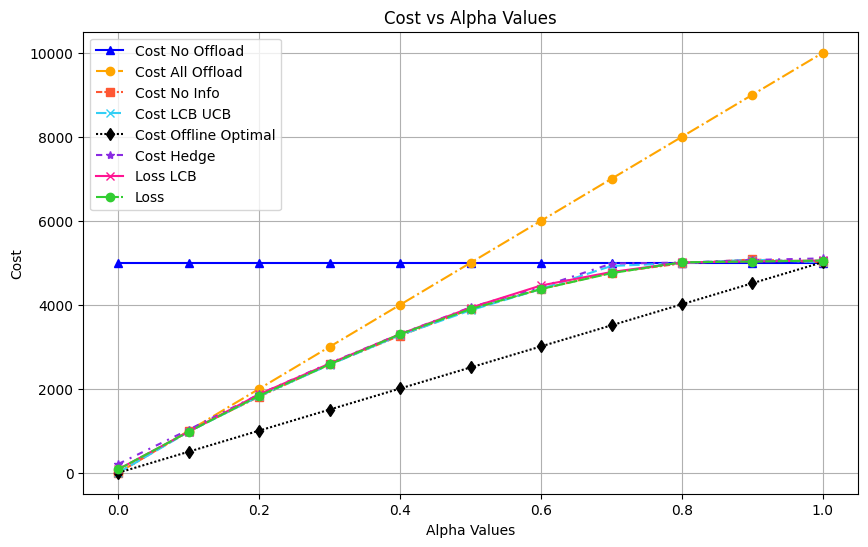

In [59]:
import matplotlib.pyplot as plt

# Alpha values
alpha_values = [round(i * 0.1, 1) for i in range(11)]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(alpha_values, cost_no_offload, linestyle='-', marker='^', label='Cost No Offload', color='blue')
plt.plot(alpha_values, cost_all_offload, linestyle='-.', marker='o', label='Cost All Offload', color='orange')
plt.plot(alpha_values, cost_no_info_list, linestyle=(0, (3, 1, 1, 1)), marker='s', label='Cost No Info', color='#FF5733')  # Dashed-dot-dot style
plt.plot(alpha_values, cost_LCB_UCB_list, linestyle=(0, (5, 2)), marker='x', label='Cost LCB UCB', color='#33CFF5')  # Longer dashes
plt.plot(alpha_values, cost_offline_optimal, linestyle=(0, (1, 1)), marker='d', label='Cost Offline Optimal', color='black')  # Dense dotted style
plt.plot(alpha_values, cost_hedge_list, linestyle=(0, (3, 3, 1, 3)), marker='*', label='Cost Hedge', color='#8A2BE2')  # Dash-dot-dash style
plt.plot(alpha_values, alpha_results_1, linestyle='-', marker='x', label='Loss LCB', color='#FF1493')  # Solid bright pink
plt.plot(alpha_values, alpha_results_2, linestyle=(0, (5, 1)), marker='o', label='Loss', color='#32CD32')  # Dense dashed bright green

# Adding labels and title
plt.xlabel('Alpha Values')
plt.ylabel('Cost')
plt.title('Cost vs Alpha Values')
plt.legend()
plt.grid()

# Show plot
plt.show()


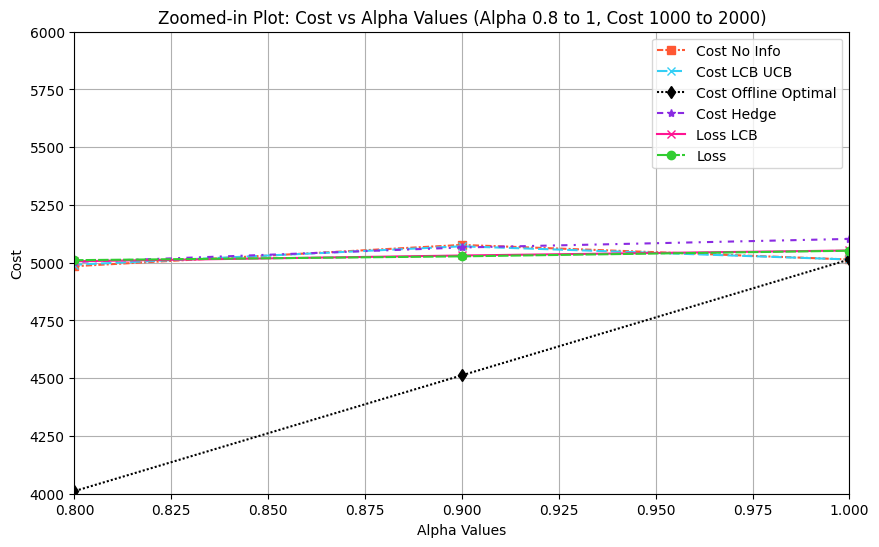

In [60]:
# Create a zoomed-in plot for the region of interest (alpha: 0.8 to 1, cost: 1000 to 2000)
plt.figure(figsize=(10, 6))

# Plot the same data for the zoomed-in region
# plt.plot(alpha_values, cost_no_offload, linestyle='-', marker='^', label='Cost No Offload', color='blue')
# plt.plot(alpha_values, cost_all_offload, linestyle='-.', marker='o', label='Cost All Offload', color='orange')
plt.plot(alpha_values, cost_no_info_list, linestyle=(0, (3, 1, 1, 1)), marker='s', label='Cost No Info', color='#FF5733')  # Dashed-dot-dot style
plt.plot(alpha_values, cost_LCB_UCB_list, linestyle=(0, (5, 2)), marker='x', label='Cost LCB UCB', color='#33CFF5')  # Longer dashes
plt.plot(alpha_values, cost_offline_optimal, linestyle=(0, (1, 1)), marker='d', label='Cost Offline Optimal', color='black')  # Dense dotted style
plt.plot(alpha_values, cost_hedge_list, linestyle=(0, (3, 3, 1, 3)), marker='*', label='Cost Hedge', color='#8A2BE2')  # Dash-dot-dash style
plt.plot(alpha_values, alpha_results_1, linestyle='-', marker='x', label='Loss LCB', color='#FF1493')  # Solid bright pink
plt.plot(alpha_values, alpha_results_2, linestyle=(0, (5, 1)), marker='o', label='Loss', color='#32CD32')  # Dense dashed bright green

# Set the limits for the zoomed-in area
plt.xlim(0.8, 1.0)
plt.ylim(4000, 6000)

# Adding labels and title for the zoomed-in plot
plt.xlabel('Alpha Values')
plt.ylabel('Cost')
plt.title('Zoomed-in Plot: Cost vs Alpha Values (Alpha 0.8 to 1, Cost 1000 to 2000)')
plt.legend()
plt.grid()

# Show the zoomed-in plot
plt.show()

In [61]:
# Algorithm - Offline optimal
cost_offline_optimal = []

# Iterate over alpha values from 0 to 1 with an increment of 0.1
# for alpha in [round(i * 0.1, 1) for i in range(11)]:
cost_current_alpha = 0.0  # Reset cost for each alpha
offload_count = {threshold: 0 for threshold in thresholds}
total_count = {threshold: 0 for threshold in thresholds}
incorrect_count = {threshold: 0 for threshold in thresholds}
correct_count = {threshold: 0 for threshold in thresholds}

alpha = 0.5

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)

        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_count[pred_probs] += 1
        # Calculate cost based on prediction accuracy
        if pred_class != true_class:
            offload_count[pred_probs] += 1
            incorrect_count[pred_probs] += 1
        else:
            correct_count[pred_probs] += 1

print(offload_count)
print(total_count)

{0.0: 0, 0.0667: 26, 0.1333: 309, 0.2: 639, 0.2667: 728, 0.3333: 638, 0.4: 584, 0.4667: 450, 0.5333: 388, 0.6: 291, 0.6667: 266, 0.7333: 186, 0.8: 168, 0.8667: 146, 0.9333: 119, 1.0: 76}
{0.0: 0, 0.0667: 29, 0.1333: 345, 0.2: 770, 0.2667: 904, 0.3333: 875, 0.4: 837, 0.4667: 739, 0.5333: 713, 0.6: 567, 0.6667: 583, 0.7333: 480, 0.8: 540, 0.8667: 637, 0.9333: 855, 1.0: 1126}


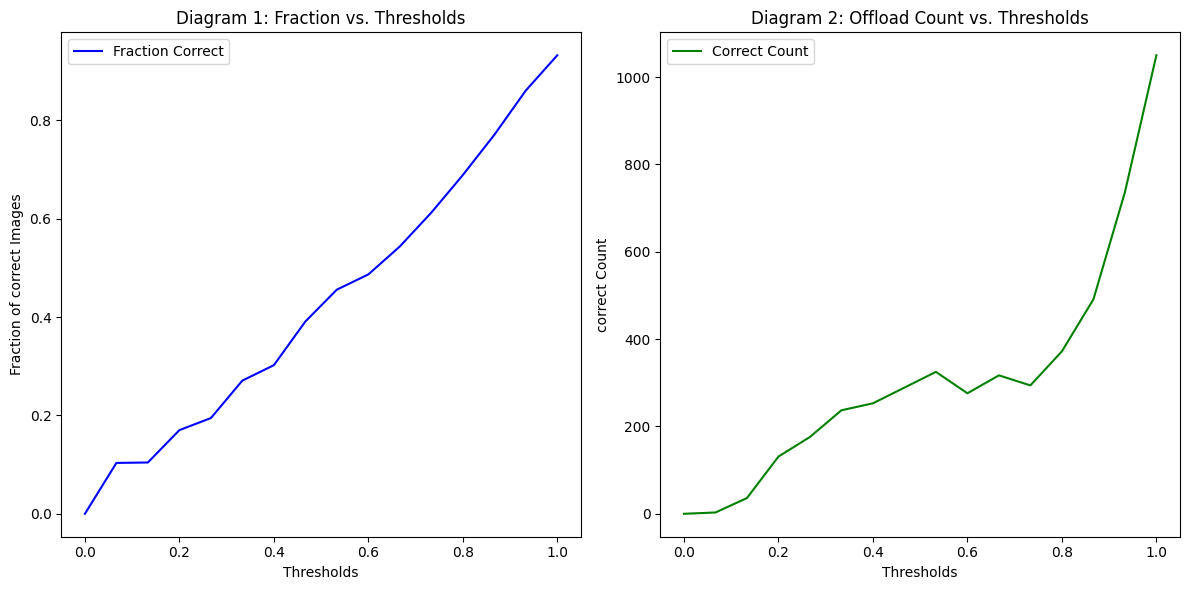

In [62]:
import matplotlib.pyplot as plt
fraction_correct = {threshold: correct_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting on the first diagram
ax1.plot(thresholds, [fraction_correct[t] for t in thresholds], label='Fraction Correct', color='blue')
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Fraction of correct Images')
ax1.set_title('Diagram 1: Fraction vs. Thresholds')
ax1.legend()

# Plotting on the second diagram (modify as needed)
ax2.plot(thresholds, [correct_count[t] for t in thresholds], label='Correct Count', color='green')
ax2.set_xlabel('Thresholds')
ax2.set_ylabel('correct Count')
ax2.set_title('Diagram 2: Offload Count vs. Thresholds')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

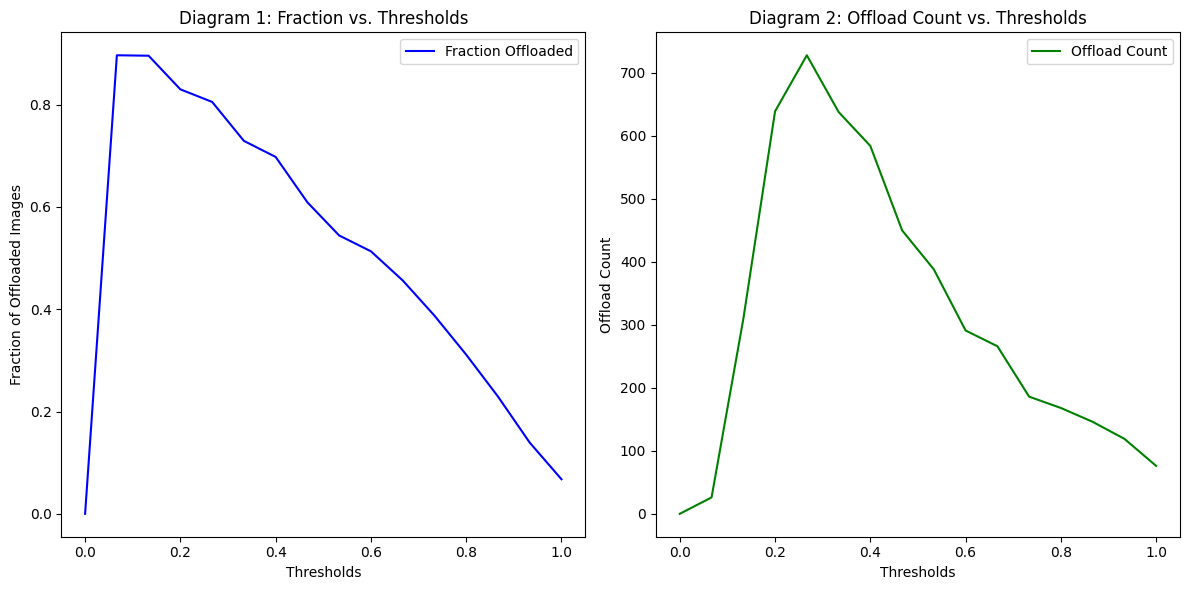

In [63]:
import matplotlib.pyplot as plt
fraction_offloaded = {threshold: offload_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting on the first diagram
ax1.plot(thresholds, [fraction_offloaded[t] for t in thresholds], label='Fraction Offloaded', color='blue')
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Fraction of Offloaded Images')
ax1.set_title('Diagram 1: Fraction vs. Thresholds')
ax1.legend()

# Plotting on the second diagram (modify as needed)
ax2.plot(thresholds, [offload_count[t] for t in thresholds], label='Offload Count', color='green')
ax2.set_xlabel('Thresholds')
ax2.set_ylabel('Offload Count')
ax2.set_title('Diagram 2: Offload Count vs. Thresholds')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

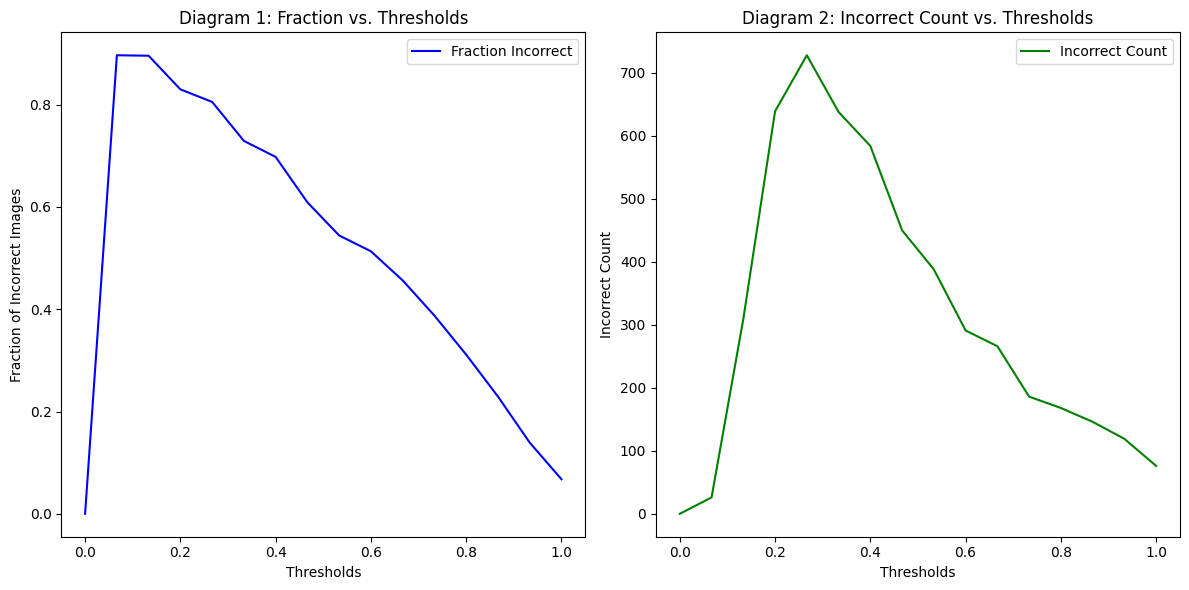

In [64]:
import matplotlib.pyplot as plt
fraction_incorrect = {threshold: incorrect_count[threshold] / total_count[threshold] if total_count[threshold] > 0 else 0 for threshold in thresholds}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting on the first diagram
ax1.plot(thresholds, [fraction_incorrect[t] for t in thresholds], label='Fraction Incorrect', color='blue')
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Fraction of Incorrect Images')
ax1.set_title('Diagram 1: Fraction vs. Thresholds')
ax1.legend()

# Plotting on the second diagram (modify as needed)
ax2.plot(thresholds, [incorrect_count[t] for t in thresholds], label='Incorrect Count', color='green')
ax2.set_xlabel('Thresholds')
ax2.set_ylabel('Incorrect Count')
ax2.set_title('Diagram 2: Incorrect Count vs. Thresholds')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [65]:
alpha = 0.6  # Fixed alpha value
delta = 1 / math.e

# Initialize regret tracker
regret_list_LCB_UCB = []
regret_list_LCB_UCB_normalized = []

# Initialize variables to track total cost for both algorithms
cost_LCB_UCB = 0.0
cost_offline_optimal = 0.0

# Dictionaries to track UCB, LCB, Tx, Fx for LCB-UCB
dict = {
    'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
    'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
    'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
    'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
}

correct_counts = {threshold: 0 for threshold in thresholds}
offloads_counts = {threshold: 0 for threshold in thresholds}
total_counts = {threshold: 0 for threshold in thresholds}

# Process each batch of images
with torch.no_grad():
    image_count = 1

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_counts[pred_probs] += 1

        # ----- LCB-UCB Algorithm -----
        if dict['LCB'][pred_probs] >= (1 - alpha):
            if pred_class != true_class:
                cost_LCB_UCB += 1  # Increment LCB-UCB cost for incorrect prediction

        elif dict['UCB'][pred_probs] <= (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        log_delta = math.log(1 / delta)
        uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

        dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
        dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

        # Update bounds for each threshold
        for x1 in thresholds:
            if x1 <= pred_probs:
                for x in thresholds:
                    if x1 <= x <= pred_probs:
                        dict['UCB'][x1] = min(dict['UCB'][x1], dict['UCB'][x])

        for x2 in thresholds:
            if x2 >= pred_probs:
                for x in thresholds:
                    if x2 >= x >= pred_probs:
                        dict['LCB'][x2] = max(dict['LCB'][x2], dict['LCB'][x])

        # ----- Offline Optimal Algorithm -----
        if pred_class != true_class:
            cost_offline_optimal += alpha  # Increment offline optimal cost for incorrect prediction

        # Track cumulative costs
#         cumulative_cost_LCB_UCB.append(cost_LCB_UCB)
#         cumulative_cost_offline_optimal.append(cost_offline_optimal)

        # Compute regret at this step
        regret = cost_LCB_UCB - cost_offline_optimal
        regret_list_LCB_UCB.append(regret)
        regret_list_LCB_UCB_normalized.append(regret/image_count)

        # Increment image count for x-axis in the plot
        image_count += 1


In [ ]:
regret_list_hedge =[]
regret_list_hedge_normalized =[]

cost_hedge = 0.0
cost_offline_optimal = 0.0

image_count = 1

def choose_threshold(weights, thresholds, W_t):
    # Create probability distribution for selecting a threshold
    probabilities = np.array([weights[theta] / W_t for theta in thresholds])
    
    # Choose a threshold based on the weight distribution
    chosen_threshold_idx = np.random.choice(len(thresholds), p=probabilities)
    chosen_threshold = thresholds[chosen_threshold_idx]
    
    return chosen_threshold

alpha = 0.6
# Iterate over different values of alpha
η = 0.02 / alpha**(1/3) if alpha > 0 else 0.02
ε = min(1, math.sqrt(η / (2 * alpha))) if alpha > 0 else 0.9

cost_hedge = 0.0
weights = {threshold: 1.0 for threshold in thresholds}  # Initialize weights for each threshold
W_t = sum(weights.values())  # Sum the initial weights to get W_t
# incorrect_count = {threshold: 0 for threshold in thresholds}
# correct_count = {threshold: 0 for threshold in thresholds}
# offload_count = {threshold: 0 for threshold in thresholds}
# total_count = {threshold: 0 for threshold in thresholds}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        p_t = round(predicted_probs.item(), 4)

        pred_class = predicted_labels.item()
        true_class = labels.item()

        # Choose a threshold based on the current weights
        chosen_threshold = choose_threshold(weights, thresholds, W_t)

#         total_count[p_t] += 1

        if p_t < chosen_threshold:
            offload_count[p_t] += 1
            cost_hedge += alpha  # Offload, cost is alpha
        else:
            if pred_class != true_class:
                incorrect_count[p_t] += 1
                cost_hedge += 1  # Incorrect prediction, full cost
            else:
                correct_count[p_t] += 1

        # Compute pseudo-loss and update weights
        if pred_class == true_class:
            Y_t = 0
        else:
            Y_t = 1
            cost_offline_optimal += alpha

        for threshold in thresholds:
            if p_t < threshold:
                pseudo_loss = alpha  # Offload cost
            else:
                pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Loss depends on epsilon

            # Update the weight for the current threshold
            weights[threshold] = weights[threshold] * np.exp(-η * pseudo_loss)

        # Recalculate W_t as the sum of all updated weights
        W_t = sum(weights.values())
        
        regret = cost_hedge - cost_offline_optimal
        regret_list_hedge.append(regret)
        regret_list_hedge_normalized.append(regret/image_count)
        
        image_count += 1


In [ ]:
alpha = 0.6  # Fixed alpha value
delta = 1 / math.e

# Initialize regret tracker
regret_list_LCB_UCB_no_info = []
regret_list_LCB_UCB_no_info_normalized = []

# Initialize variables to track total cost for both algorithms
cost_LCB_UCB = 0.0
cost_offline_optimal = 0.0

# Dictionaries to track UCB, LCB, Tx, Fx for LCB-UCB
dict = {
    'UCB': {threshold: 1.0 for threshold in thresholds},  # Upper confidence bound
    'LCB': {threshold: 0.0 for threshold in thresholds},  # Lower confidence bound
    'Tx': {threshold: 0 for threshold in thresholds},     # Count of times each threshold has been reached
    'Fx': {threshold: 0 for threshold in thresholds},     # Fraction of correct predictions
}

correct_counts = {threshold: 0 for threshold in thresholds}
offloads_counts = {threshold: 0 for threshold in thresholds}
total_counts = {threshold: 0 for threshold in thresholds}

# Process each batch of images
with torch.no_grad():
    image_count = 1

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs and softmax probabilities
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        # Quantize probabilities to 8-bit
        quantized_probs = quantize_to_8bit(softmax_probs)

        # Get the predicted probabilities and classes
        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        total_counts[pred_probs] += 1

        # ----- LCB-UCB Algorithm -----
        if dict['LCB'][pred_probs] >= (1 - alpha):
            if pred_class != true_class:
                cost_LCB_UCB += 1  # Increment LCB-UCB cost for incorrect prediction

        elif dict['UCB'][pred_probs] <= (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        elif dict['UCB'][pred_probs] > (1 - alpha) and dict['LCB'][pred_probs] < (1 - alpha):
            dict['Tx'][pred_probs] += 1
            if pred_class == true_class:
                correct_counts[pred_probs] += 1
            dict['Fx'][pred_probs] = correct_counts[pred_probs] / dict['Tx'][pred_probs]
            offloads_counts[pred_probs] += 1
            cost_LCB_UCB += alpha

        log_delta = math.log(1 / delta)
        uncertainty = math.sqrt(log_delta / dict['Tx'][pred_probs]) if dict['Tx'][pred_probs] > 0 else 1.0

        dict['UCB'][pred_probs] = min(1, dict['Fx'][pred_probs] + uncertainty)
        dict['LCB'][pred_probs] = max(0, dict['Fx'][pred_probs] - uncertainty)

        # ----- Offline Optimal Algorithm -----
        if pred_class != true_class:
            cost_offline_optimal += alpha  # Increment offline optimal cost for incorrect prediction

        # Compute regret at this step
        regret = cost_LCB_UCB - cost_offline_optimal
        regret_list_LCB_UCB_no_info.append(regret)
        regret_list_LCB_UCB_no_info_normalized.append(regret/image_count)

        # Increment image count for x-axis in the plot
        image_count += 1


In [ ]:
alpha = 0.6

cost_Loss_LCB = 0.0
cost_offline_optimal = 0.0

regret_list_Loss_LCB = []
regret_list_Loss_LCB_normalized = []

loss_hat = {threshold: 0.0 for threshold in thresholds}

η = 0.02 / alpha**(1/3)
ε = min(1, math.sqrt(η / (2 * alpha)))

image_count = 1

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        quantized_probs = quantize_to_8bit(softmax_probs)

        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t] - math.log(math.e / (T_x[t] + 1e-8))))

        if pred_probs < best_threshold:
            cost_Loss_LCB += alpha  # Offload, cost is alpha
        else:
            if pred_class != true_class:
                cost_Loss_LCB += 1  # Incorrect prediction, full cost

        Y_t = 0 if pred_class == true_class else 1

        for threshold in thresholds:
            if pred_probs < threshold:
                pseudo_loss = alpha  # Offload cost
            else:
                pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

            loss_hat[threshold] += pseudo_loss
            
        if pred_class != true_class:
            cost_offline_optimal += alpha
        
        regret = cost_Loss_LCB - cost_offline_optimal
        regret_list_Loss_LCB.append(regret)
        regret_list_Loss_LCB_normalized.append(regret/image_count)

        image_count += 1


In [69]:
alpha = 0.6

cost_Loss = 0.0
cost_offline_optimal = 0.0

regret_list_Loss = []
regret_list_Loss_normalized = []

loss_hat = {threshold: 0.0 for threshold in thresholds}

η = 0.02 / alpha**(1/3)
ε = min(1, math.sqrt(η / (2 * alpha)))

image_count = 1

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)

        quantized_probs = quantize_to_8bit(softmax_probs)

        predicted_probs, predicted_labels = torch.max(quantized_probs, dim=1)
        pred_probs = round(predicted_probs.item(), 4)
        pred_class = predicted_labels.item()
        true_class = labels.item()

        best_threshold = min(thresholds, key=lambda t: max(0, loss_hat[t]))

        if pred_probs < best_threshold:
            cost_Loss_LCB += alpha  # Offload, cost is alpha
        else:
            if pred_class != true_class:
                cost_Loss_LCB += 1  # Incorrect prediction, full cost

        Y_t = 0 if pred_class == true_class else 1

        for threshold in thresholds:
            if pred_probs < threshold:
                pseudo_loss = alpha  # Offload cost
            else:
                pseudo_loss = Y_t / ε if np.random.binomial(1, ε) else 0  # Conditional loss based on epsilon

            loss_hat[threshold] += pseudo_loss
            
        if pred_class != true_class:
            cost_offline_optimal += alpha
        
        regret = cost_Loss - cost_offline_optimal
        regret_list_Loss.append(regret)
        regret_list_Loss_normalized.append(regret/image_count)

        image_count += 1


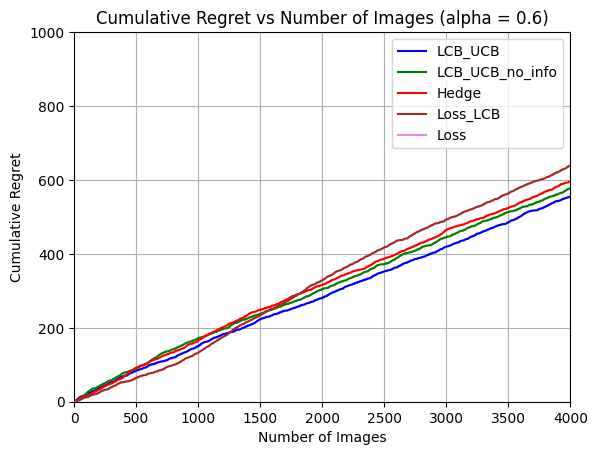

In [70]:
import matplotlib.pyplot as plt

# Your existing plot code
plt.plot(range(1, image_count), regret_list_LCB_UCB, label='LCB_UCB', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info, label='LCB_UCB_no_info', color='g')
plt.plot(range(1, image_count), regret_list_hedge, label='Hedge', color='r')
plt.plot(range(1, image_count), regret_list_Loss_LCB, label='Loss_LCB', color='brown')
plt.plot(range(1, image_count), regret_list_Loss, label='Loss', color='violet')

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret vs Number of Images (alpha = 0.6)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Set limits for both axes to scale of 500
plt.xlim(0, 4000)
plt.ylim(0, 1000)

# Show the plot
plt.show()


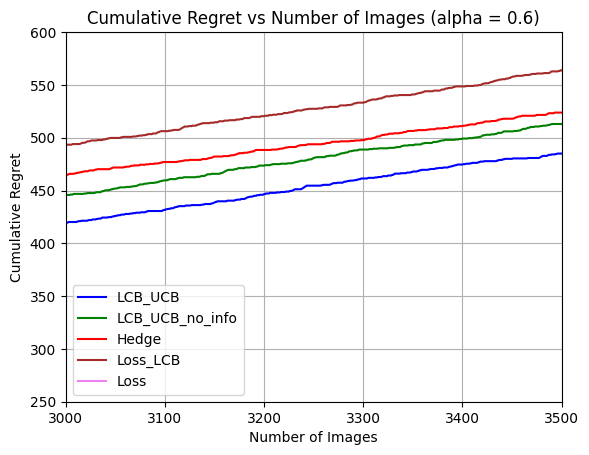

In [71]:
import matplotlib.pyplot as plt

# Your existing plot code
plt.plot(range(1, image_count), regret_list_LCB_UCB, label='LCB_UCB', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info, label='LCB_UCB_no_info', color='g')
plt.plot(range(1, image_count), regret_list_hedge, label='Hedge', color='r')
plt.plot(range(1, image_count), regret_list_Loss_LCB, label='Loss_LCB', color='brown')
plt.plot(range(1, image_count), regret_list_Loss, label='Loss', color='violet')

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret vs Number of Images (alpha = 0.6)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Set limits for both axes to scale of 500
plt.xlim(3000, 3500)
plt.ylim(250, 600)

# Show the plot
plt.show()


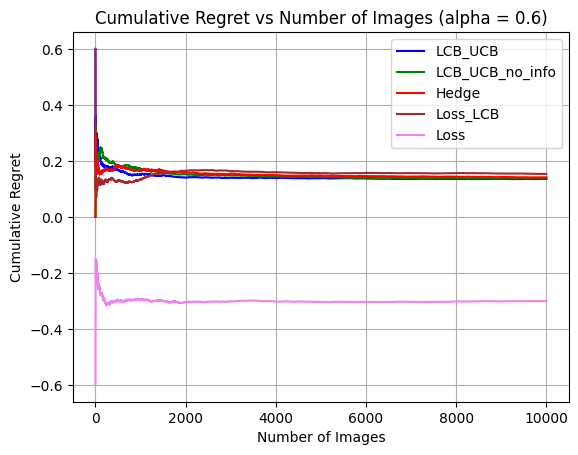

In [72]:
# Plotting cumulative regret for all three algorithms in the same graph
plt.plot(range(1, image_count), regret_list_LCB_UCB_normalized, label='LCB_UCB', color='b')
plt.plot(range(1, image_count), regret_list_LCB_UCB_no_info_normalized, label='LCB_UCB_no_info', color='g')
plt.plot(range(1, image_count), regret_list_hedge_normalized, label='Hedge', color='r')
plt.plot(range(1, image_count), regret_list_Loss_LCB_normalized, label='Loss_LCB', color='brown')
plt.plot(range(1, image_count), regret_list_Loss_normalized, label='Loss', color='violet')

# Adding labels, title, and legend
plt.xlabel('Number of Images')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret vs Number of Images (alpha = 0.6)')

# Displaying the legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


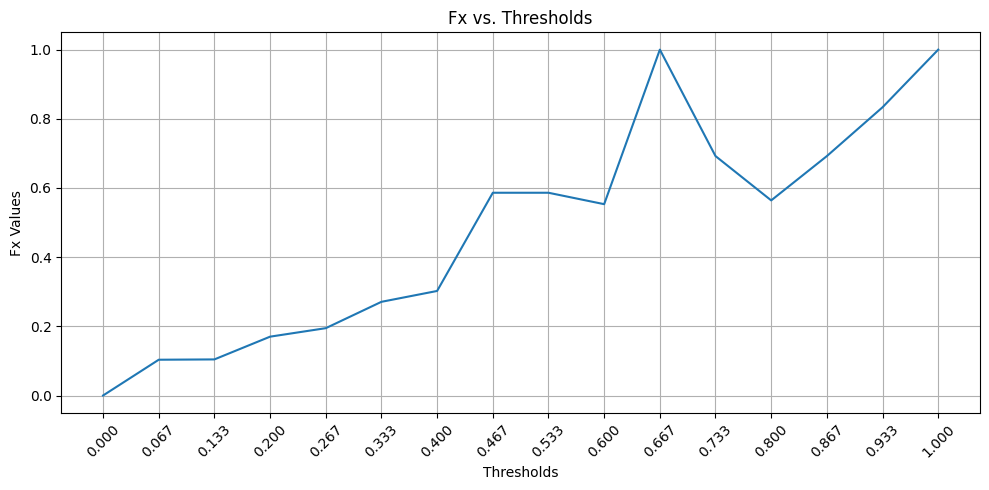

In [73]:
import matplotlib.pyplot as plt

# Assuming you already have `thresholds` and `dict['Fx']` populated

# Prepare data for plotting
threshold_values = list(thresholds)
fx_values = [dict['Fx'][threshold] for threshold in thresholds]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(threshold_values, fx_values)
plt.title('Fx vs. Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Fx Values')
plt.xticks(threshold_values, rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to make room for labels
plt.show()
